# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a picture from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [2590]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

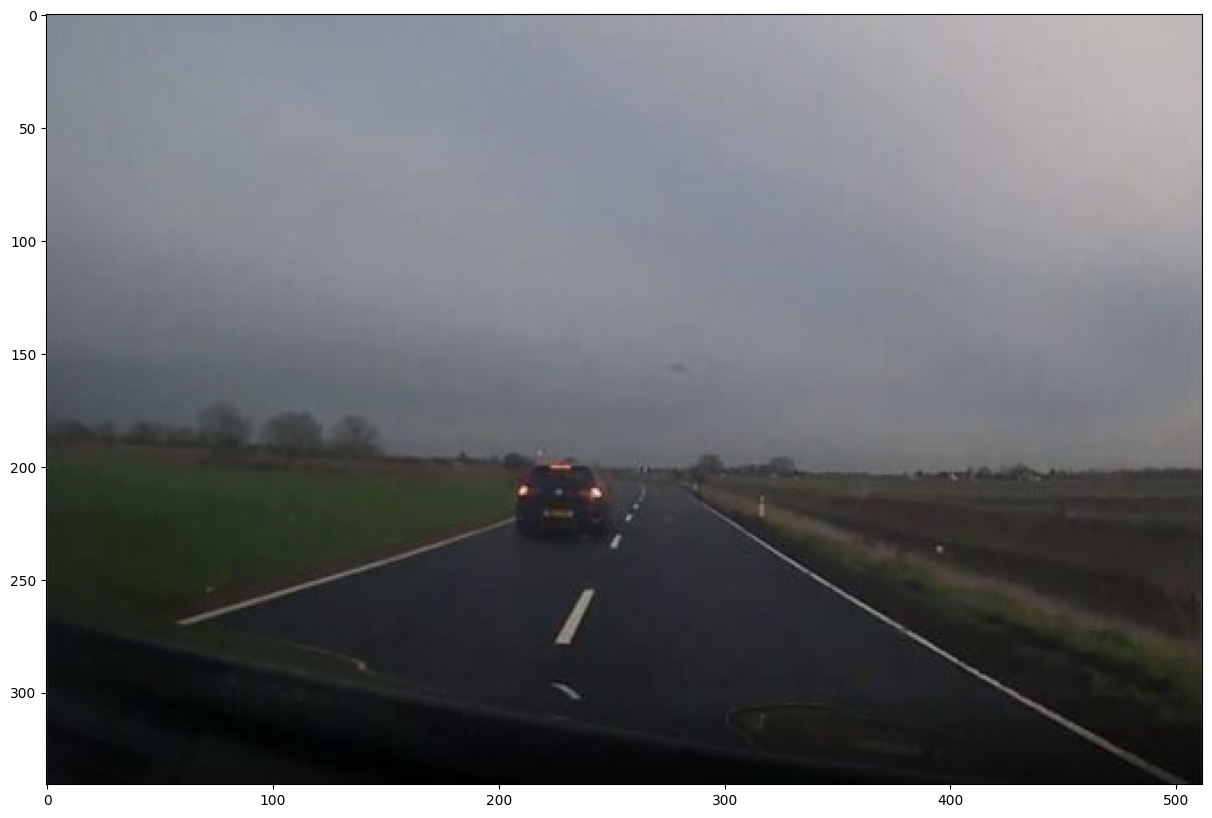

In [2591]:
img = cv2.imread('./data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

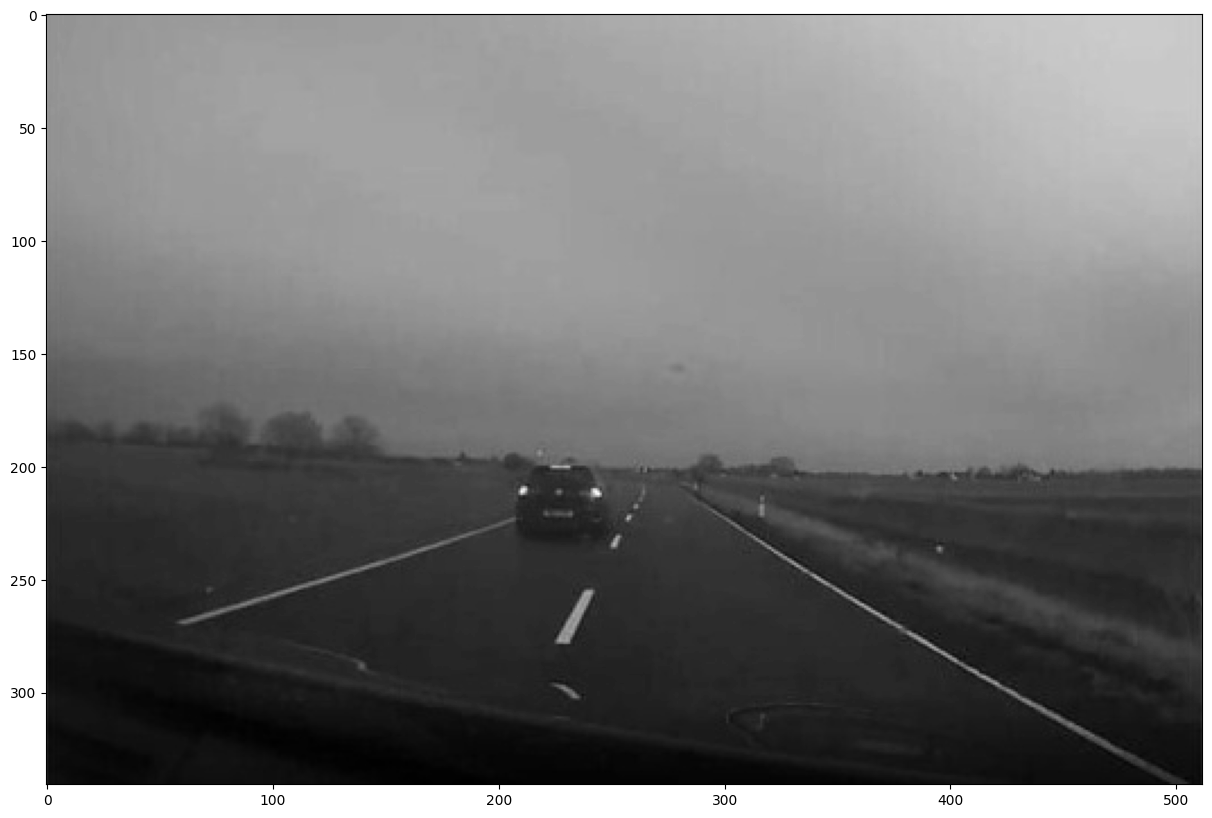

In [2592]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap="gray")

In [2593]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, 100, 150)

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

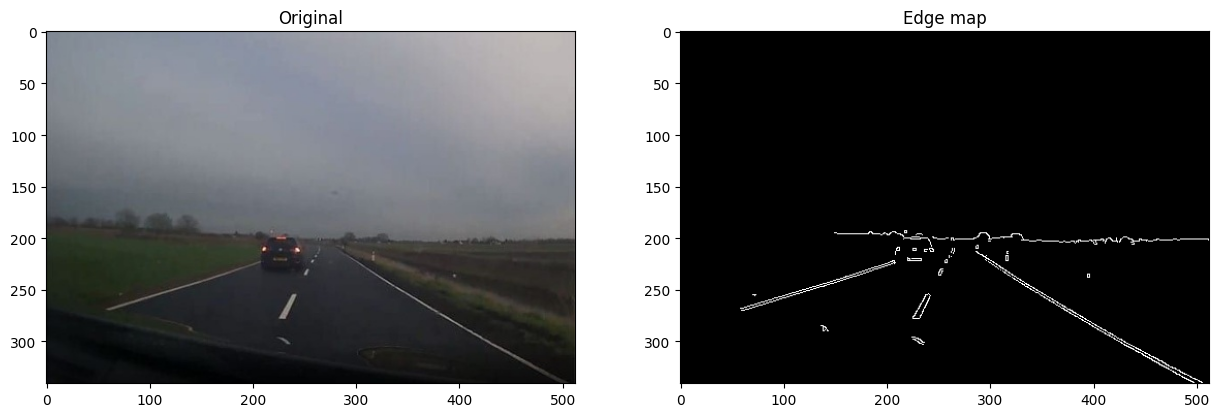

In [2594]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [2595]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 5 pixels and slope resolution of 5 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 90
# lines = cv2.HoughLines(edges, rho=5, theta=5*np.pi/180, threshold=90)
lines = cv2.HoughLines(edges, rho=2, theta=10*np.pi/180, threshold=60) # я підібрав власні параметри
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

In [2596]:
def plot_Hough_lines(lines):
    # Plot the resulting Hough lines
    result = np.copy(img)
            
    for line in lines:
        rho = line[0]
        theta = line[1]
        
        a = math.cos(theta)
        b = math.sin(theta)
        
        x0 = a * rho
        y0 = b * rho
        
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        
        cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
    return result

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

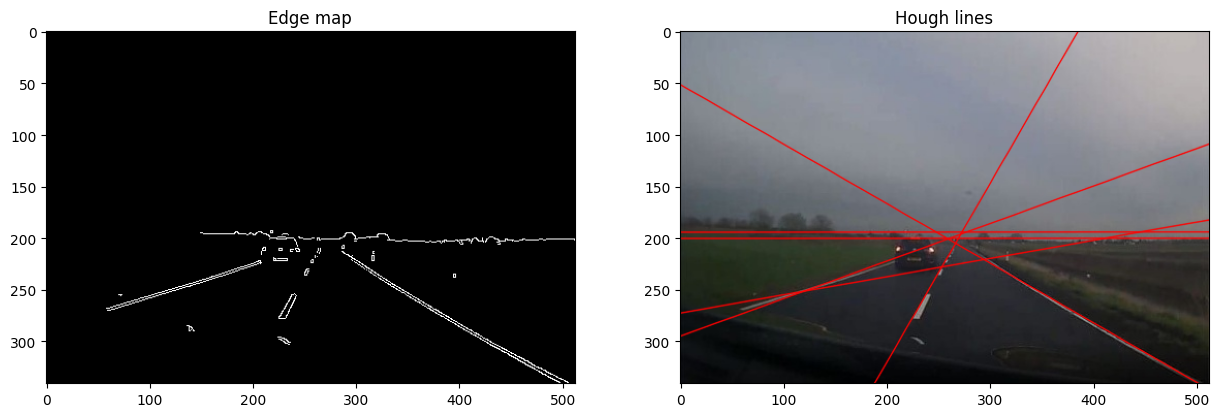

In [2597]:
result = plot_Hough_lines(lines)
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [2598]:
# Filter out all lines that are approximately horizontal (+/- 15 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    # Keep line if theta is not horizontal
    if (theta < (75 * np.pi / 180)) or (theta > (105 * np.pi / 180)):
        filtered_lines.append(line)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

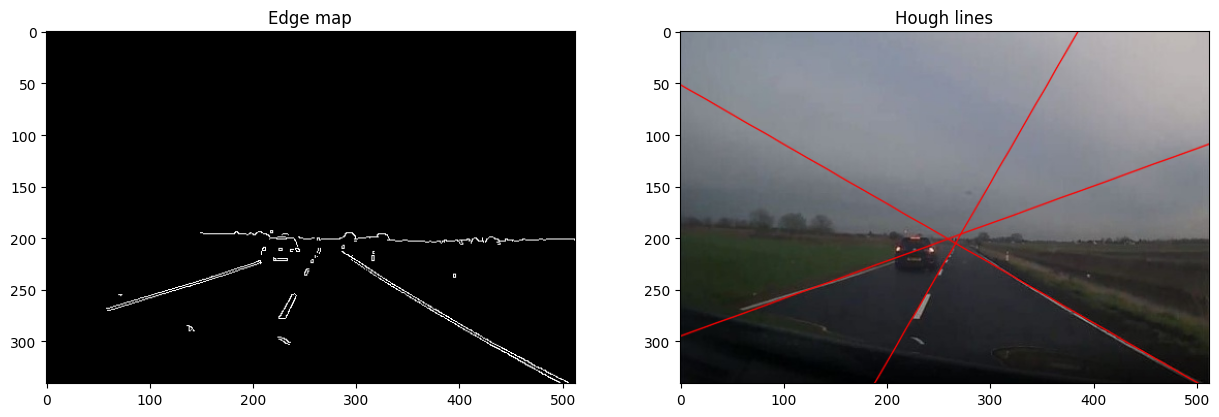

In [2599]:
# Let's plot the resulting filtered lines
result = plot_Hough_lines(filtered_lines)
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 3 lines and use the averages.

In [2600]:
# We will apply k-means clustering to refine the detected lines.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(filtered_lines)
kmeans.cluster_centers_

array([[ 45.        ,   2.09439516],
       [333.        ,   0.52359879],
       [277.        ,   1.22173047]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

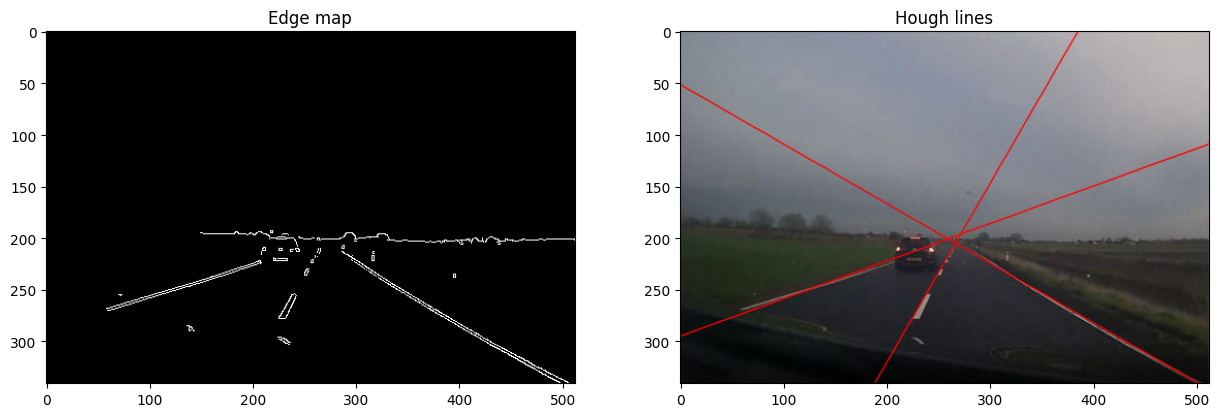

In [2601]:
# Again, let's plot the resulting filtered lines
result = plot_Hough_lines(kmeans.cluster_centers_)
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?
* Do you think the Hough transform resolution is important for obtaining a good result? Why?
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?
### Відповіді
- Так, іноді лінії які генеруються можуть не співпадати із дорожніми полосами, тому як на мене, потрібн робити підбір параметрів. А взагалі мені цей алгоритм не подобається.
- Так, роздільна здатність важлива. Збільшення цього параметра може призвести до збільшення кількості виявлених ліній, але з іншого боку, це може знизити точність виявлення окремих ліній, які є близькими за значенням. Зменшення - збільшує точність, але може зменшити кількість виявлених ліній.
- Так, threshold - задає поріг для накопичувача в перетворенні Хафа. Це значення регулює кількість голосів, необхідних для виявлення лінії. Менший поріг - більше ліній(навіть не точних) появиться в результаті. Більший поріг - менше ліній на виході, зате ці лінії матимуть більшу *впевненість* (тобто це наврядчи шуми). 

Також хотів відзначити що використання kmean як намене - сумнівне. Адже якщо передавати фото на йому не 3 полоси а 4,5... тому можуть виникнути проблемки. Але саму ідею я зрозумів.

ps. я там підбирав параметри для функції Хафа, тому що результат мене не влаштовував, тому вони не такі як в підказках. А ну і мені не подобається цей алгоритм тому що при зміні фотографії - параметри потрібно заново підбирати, а значить в режимі реального часу працювати це не буде. :)